In [12]:
%pylab inline
import cv2
import numpy as np
import logging
import math

Populating the interactive namespace from numpy and matplotlib


# Debugging and Display Utils

In [13]:
def display_frame(cap, index):
    ''' Display a frame from a video capture stream. '''
    frame = get_frame(cap, index)
    display_image(frame)

In [14]:
def display_image(image):
    ''' Show an image in a matplotlib figure. '''
    # If colored, swap color order to RGB
    if len(image.shape) > 2:
        image = image[:,:,[2,1,0]]
        imshow(image)
    else:
        imshow(image, cmap=cm.Greys)

In [15]:
def display_image_matrix(images, imgsize=(8, 5)):
    ''' Show matrix of images of variable size. '''
    if len(images) == 0 or len(images[0]) == 0:
        return
    rows = len(images)
    cols = len(images[0])
    w, h = imgsize
    figure(figsize=(w * cols, h * rows))
    for r, row in enumerate(images):
        for c, img in enumerate(row):
            spn = r * cols + c + 1
            subplot(rows, cols, spn)
            display_image(img)

In [16]:
def draw_rectangle(image, rect):
    ''' Draw a rectangle on an image. '''
    l, t, w, h = rect
    cv2.rectangle(image, 
        (l, t),
        (l + w, t + h), 
        (0, 255, 0), 10)

In [17]:
''' Helpers for fetching specific frames. '''
get_findex = lambda : int(cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES))
set_findex = lambda f : cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, f)

In [18]:
def get_frame(cap, index):
    ''' Modified from code on SO question, "How to process images of a video, frame 
        by frame in video streaming using Opencv python "'''
    
    set_findex(index)    
    logging.debug("Fetching frame %d", index)

    while True:
        flag, frame = cap.read()    
        if flag:
            logging.debug("Got frame %d", index)
            return frame
            break
        else:
            logging.debug("Frame %d not ready, trying again", findex)
            # The frame number increments after a read attempt.
            # Furthermore, to try to read frame i, we set frame number to i + 1.
            # I don't know why, but this is just how the API works.
            index = get_findex()
            set_findex(index)
            cv2.waitKey(500)

# Main Tests

###Preparation

Load up stream 

In [19]:
cap = cv2.VideoCapture('./video.mp4')  # Initialize the video stream

In [20]:
fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
frame_at_time = lambda s: int(math.ceil(s * fps))

Show that we can display frames of video by index

In [21]:
figure(figsize=(20, 50))
subplot(1, 3, 1)
display_frame(cap, 570)
subplot(1, 3, 2)
display_frame(cap, 600)
subplot(1, 3, 3)
display_frame(cap, 5000)

Show that we can display frames of video at times, indexed by second

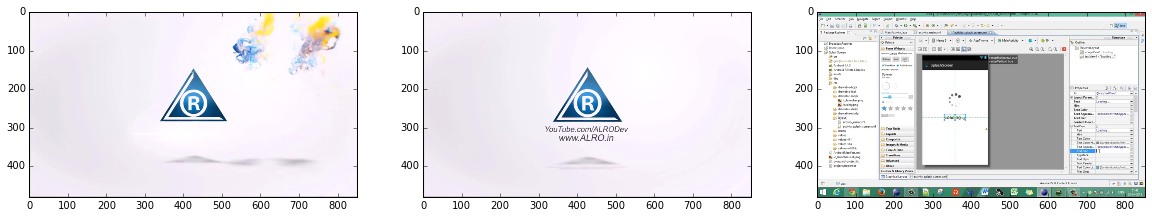

In [22]:
figure(figsize=(20, 50))
subplot(1, 3, 1)
display_frame(cap, frame_at_time(1))
subplot(1, 3, 2)
display_frame(cap, frame_at_time(2))
subplot(1, 3, 3)
display_frame(cap, frame_at_time(200))

### Fetch frames of interest

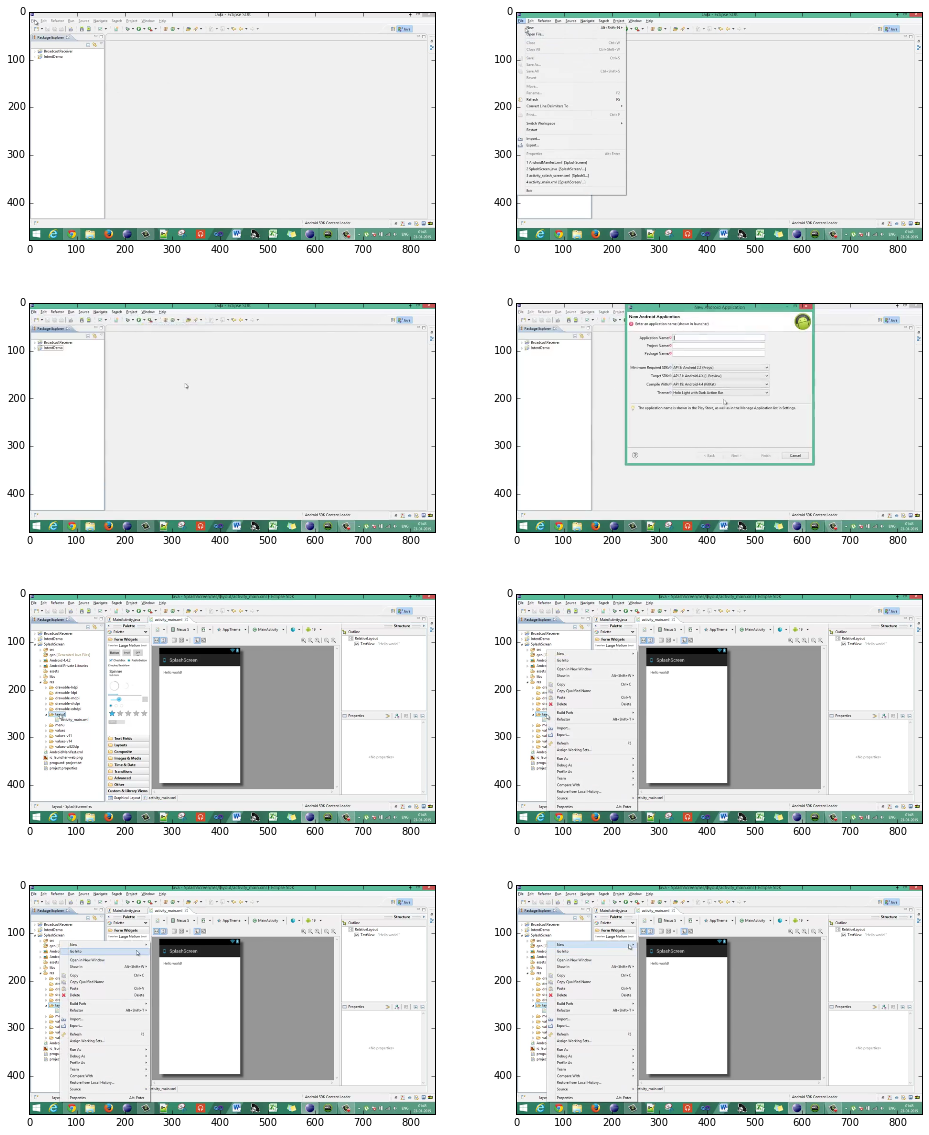

In [23]:
# Each event is a tuple of (time_before, time_after)
events = [
    [22.5, 23],   # open file menu
    [27, 27.5],   # open New Android Application dialog
    [99.8, 100.2],  # open context menu for folder
    [100.5, 101], # highlight "New" label in context menu
]
frames = []
for e in events:
    findexes = [frame_at_time(t) for t in e]
    frames.append([get_frame(cap, f) for f in findexes])

display_image_matrix(frames)

### Compute differences between pairs

In [24]:
def get_smooth_diff(fend, frames_before=10):
    ''' Get a smooth difference up to a frame by adding up the differences from
        a sequence of earlier frames and normalizing based on the largest difference
        found.  Has an effect of canceling out some noise.  '''
    
    frame_shape = get_frame(cap, fend).shape
    diff = np.zeros(frame_shape, dtype='uint32')
    for f in range(fend - frames_before, fend + 1):
        f1 = get_frame(cap, f)
        f2 = get_frame(cap, f + 1)
        diff += (f2 - f1)
    
    diff_norm = diff * (255.0 / np.max(diff))
    diff_norm = diff_norm.astype('uint8')
    diff_norm = cv2.cvtColor(diff_norm, cv2.COLOR_RGB2GRAY)
    return diff_norm

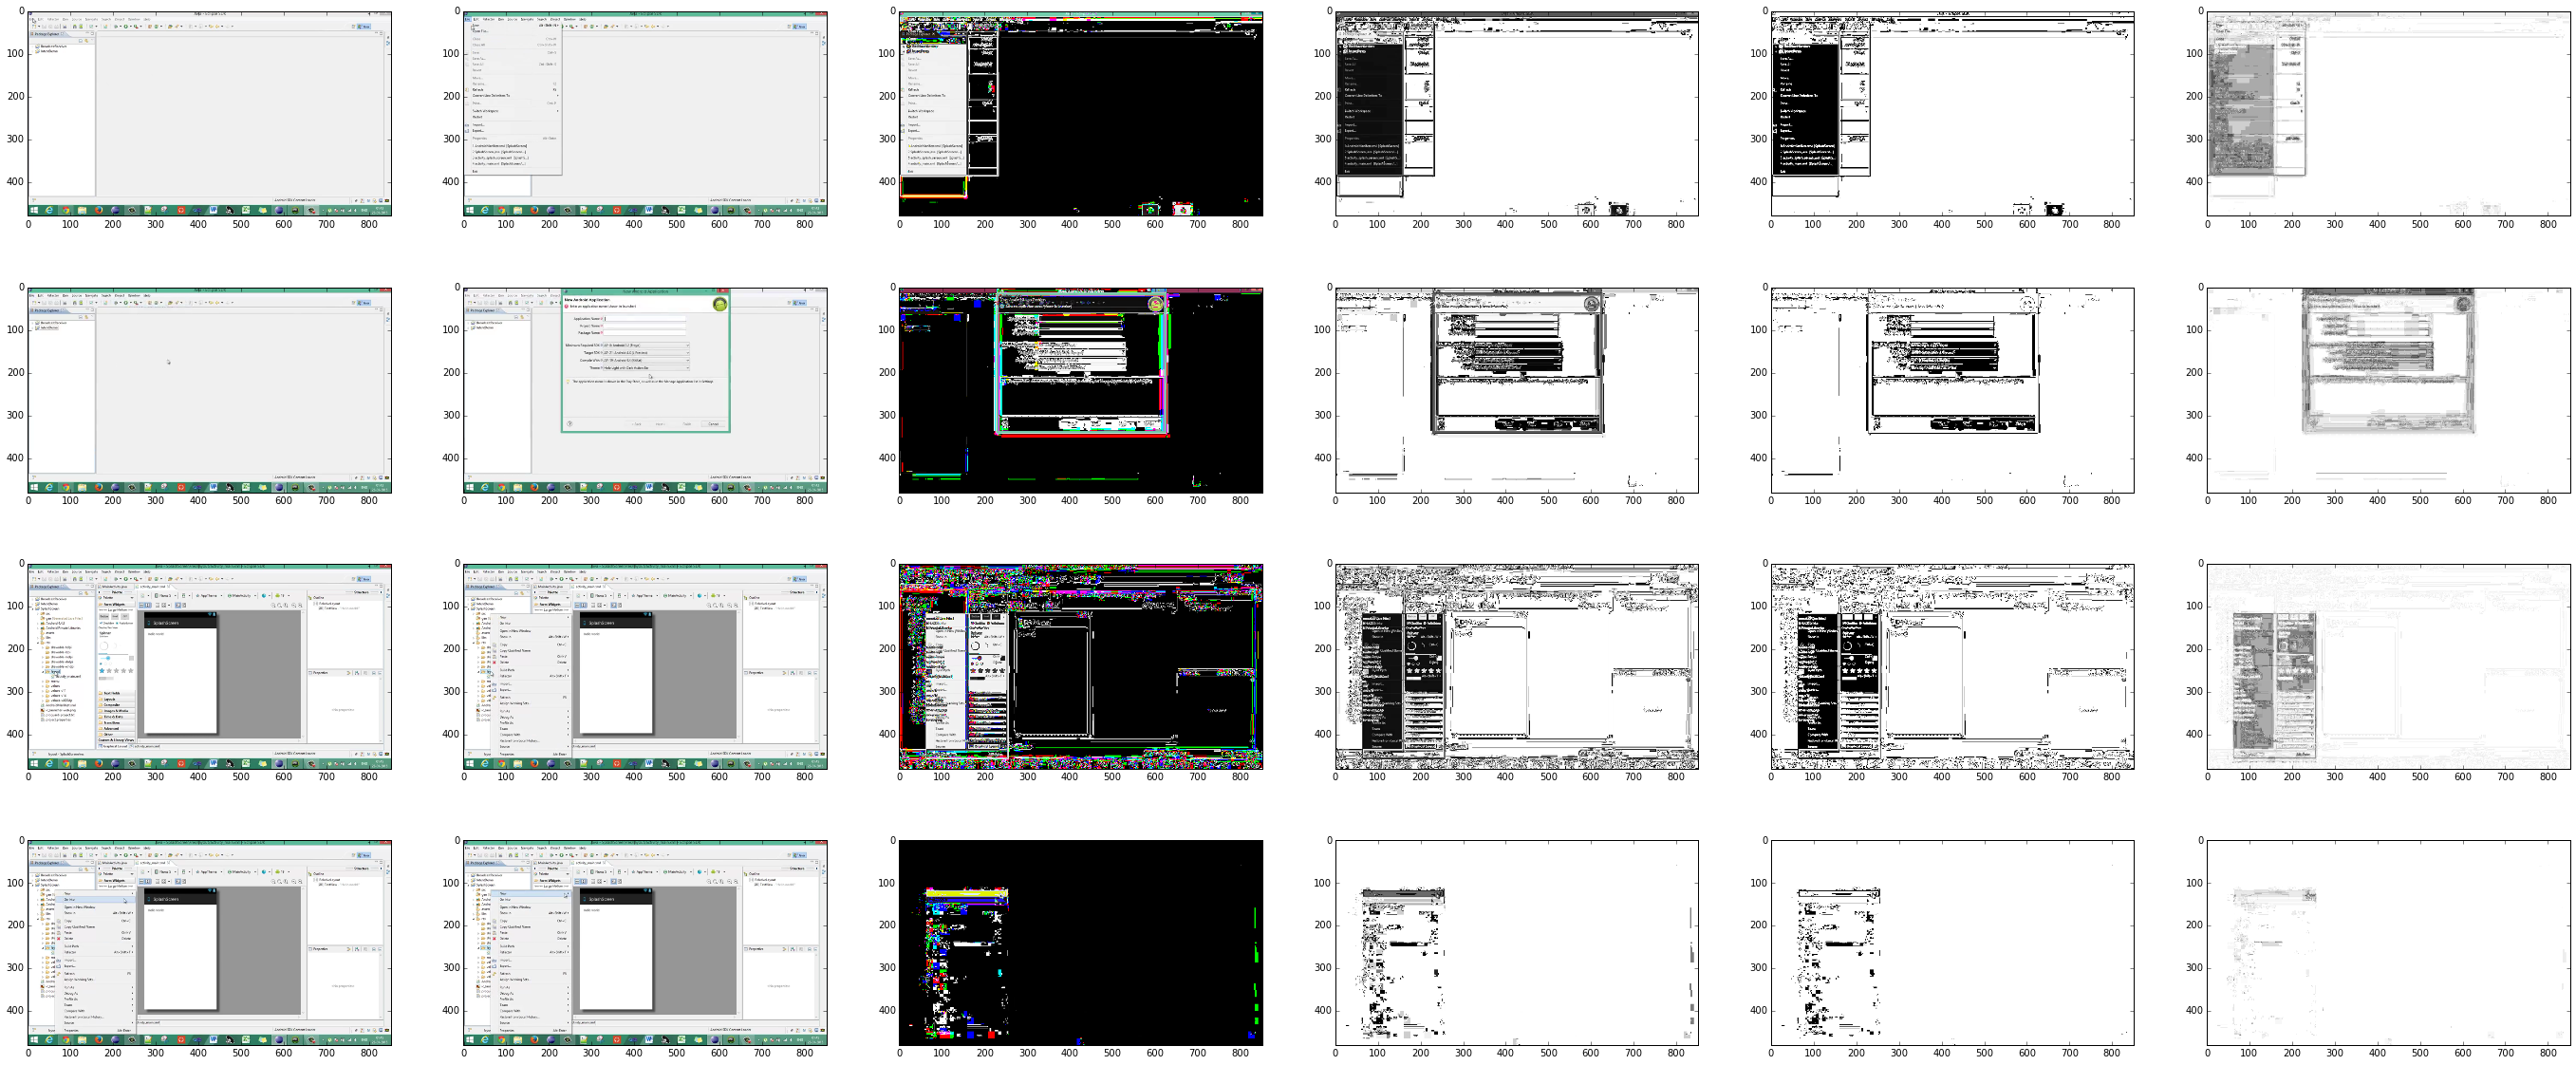

In [25]:
frames_with_diffs = []

for e in events:
    
    findexes = [frame_at_time(t) for t in e]
    fp = [get_frame(cap, f) for f in findexes] 
    diff = np.abs(fp[1] - fp[0])
    
    diff_grey = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    diff_threshold = diff_grey > 200
    smooth_diff = get_smooth_diff(findexes[1])
    
    fp_with_diffs = fp + [diff, diff_grey, diff_threshold, smooth_diff]
    frames_with_diffs.append(fp_with_diffs)

display_image_matrix(frames_with_diffs)

### Extract regions of change for menus

Display the frame differences for our menu events

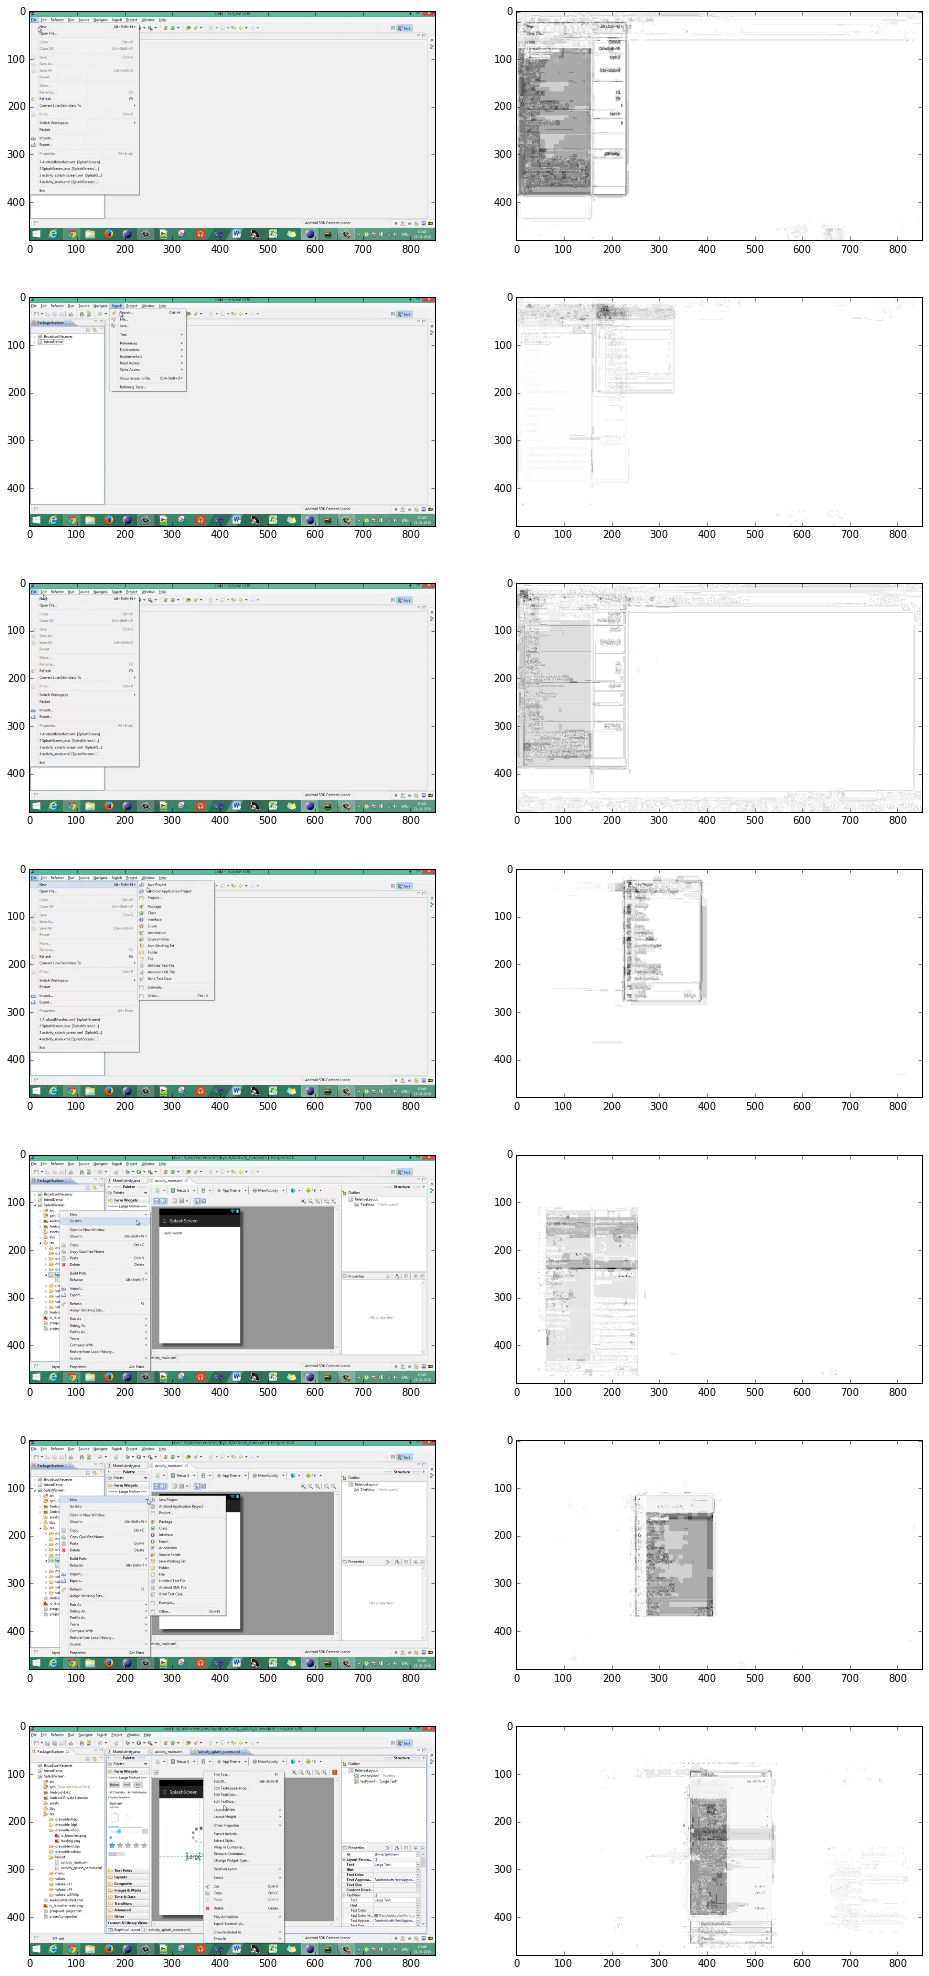

In [79]:
menu_times = [23, 23.7, 25, 26, 100.5, 101.5, 177.5]
images = []

for t in menu_times:
    findex = frame_at_time(t)
    frame = get_frame(cap, findex)
    diff = get_smooth_diff(findex)
    images.append([frame, diff])
    
display_image_matrix(images)

In [80]:
to_rgb = lambda img: cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [81]:
def blur_image(image, ksize=(15,15), sigma=7):
    return cv2.GaussianBlur(image, ksize, sigma)

In [85]:
def binarize(image, threshold=30):
    _, binarized = cv2.threshold(image.copy(), threshold, 255, cv2.THRESH_BINARY)
    scaled = binarized
    return scaled

In [86]:
def get_contours(image, minarea=5000):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = filter(lambda c: cv2.contourArea(c) > 5000, contours)
    return contours

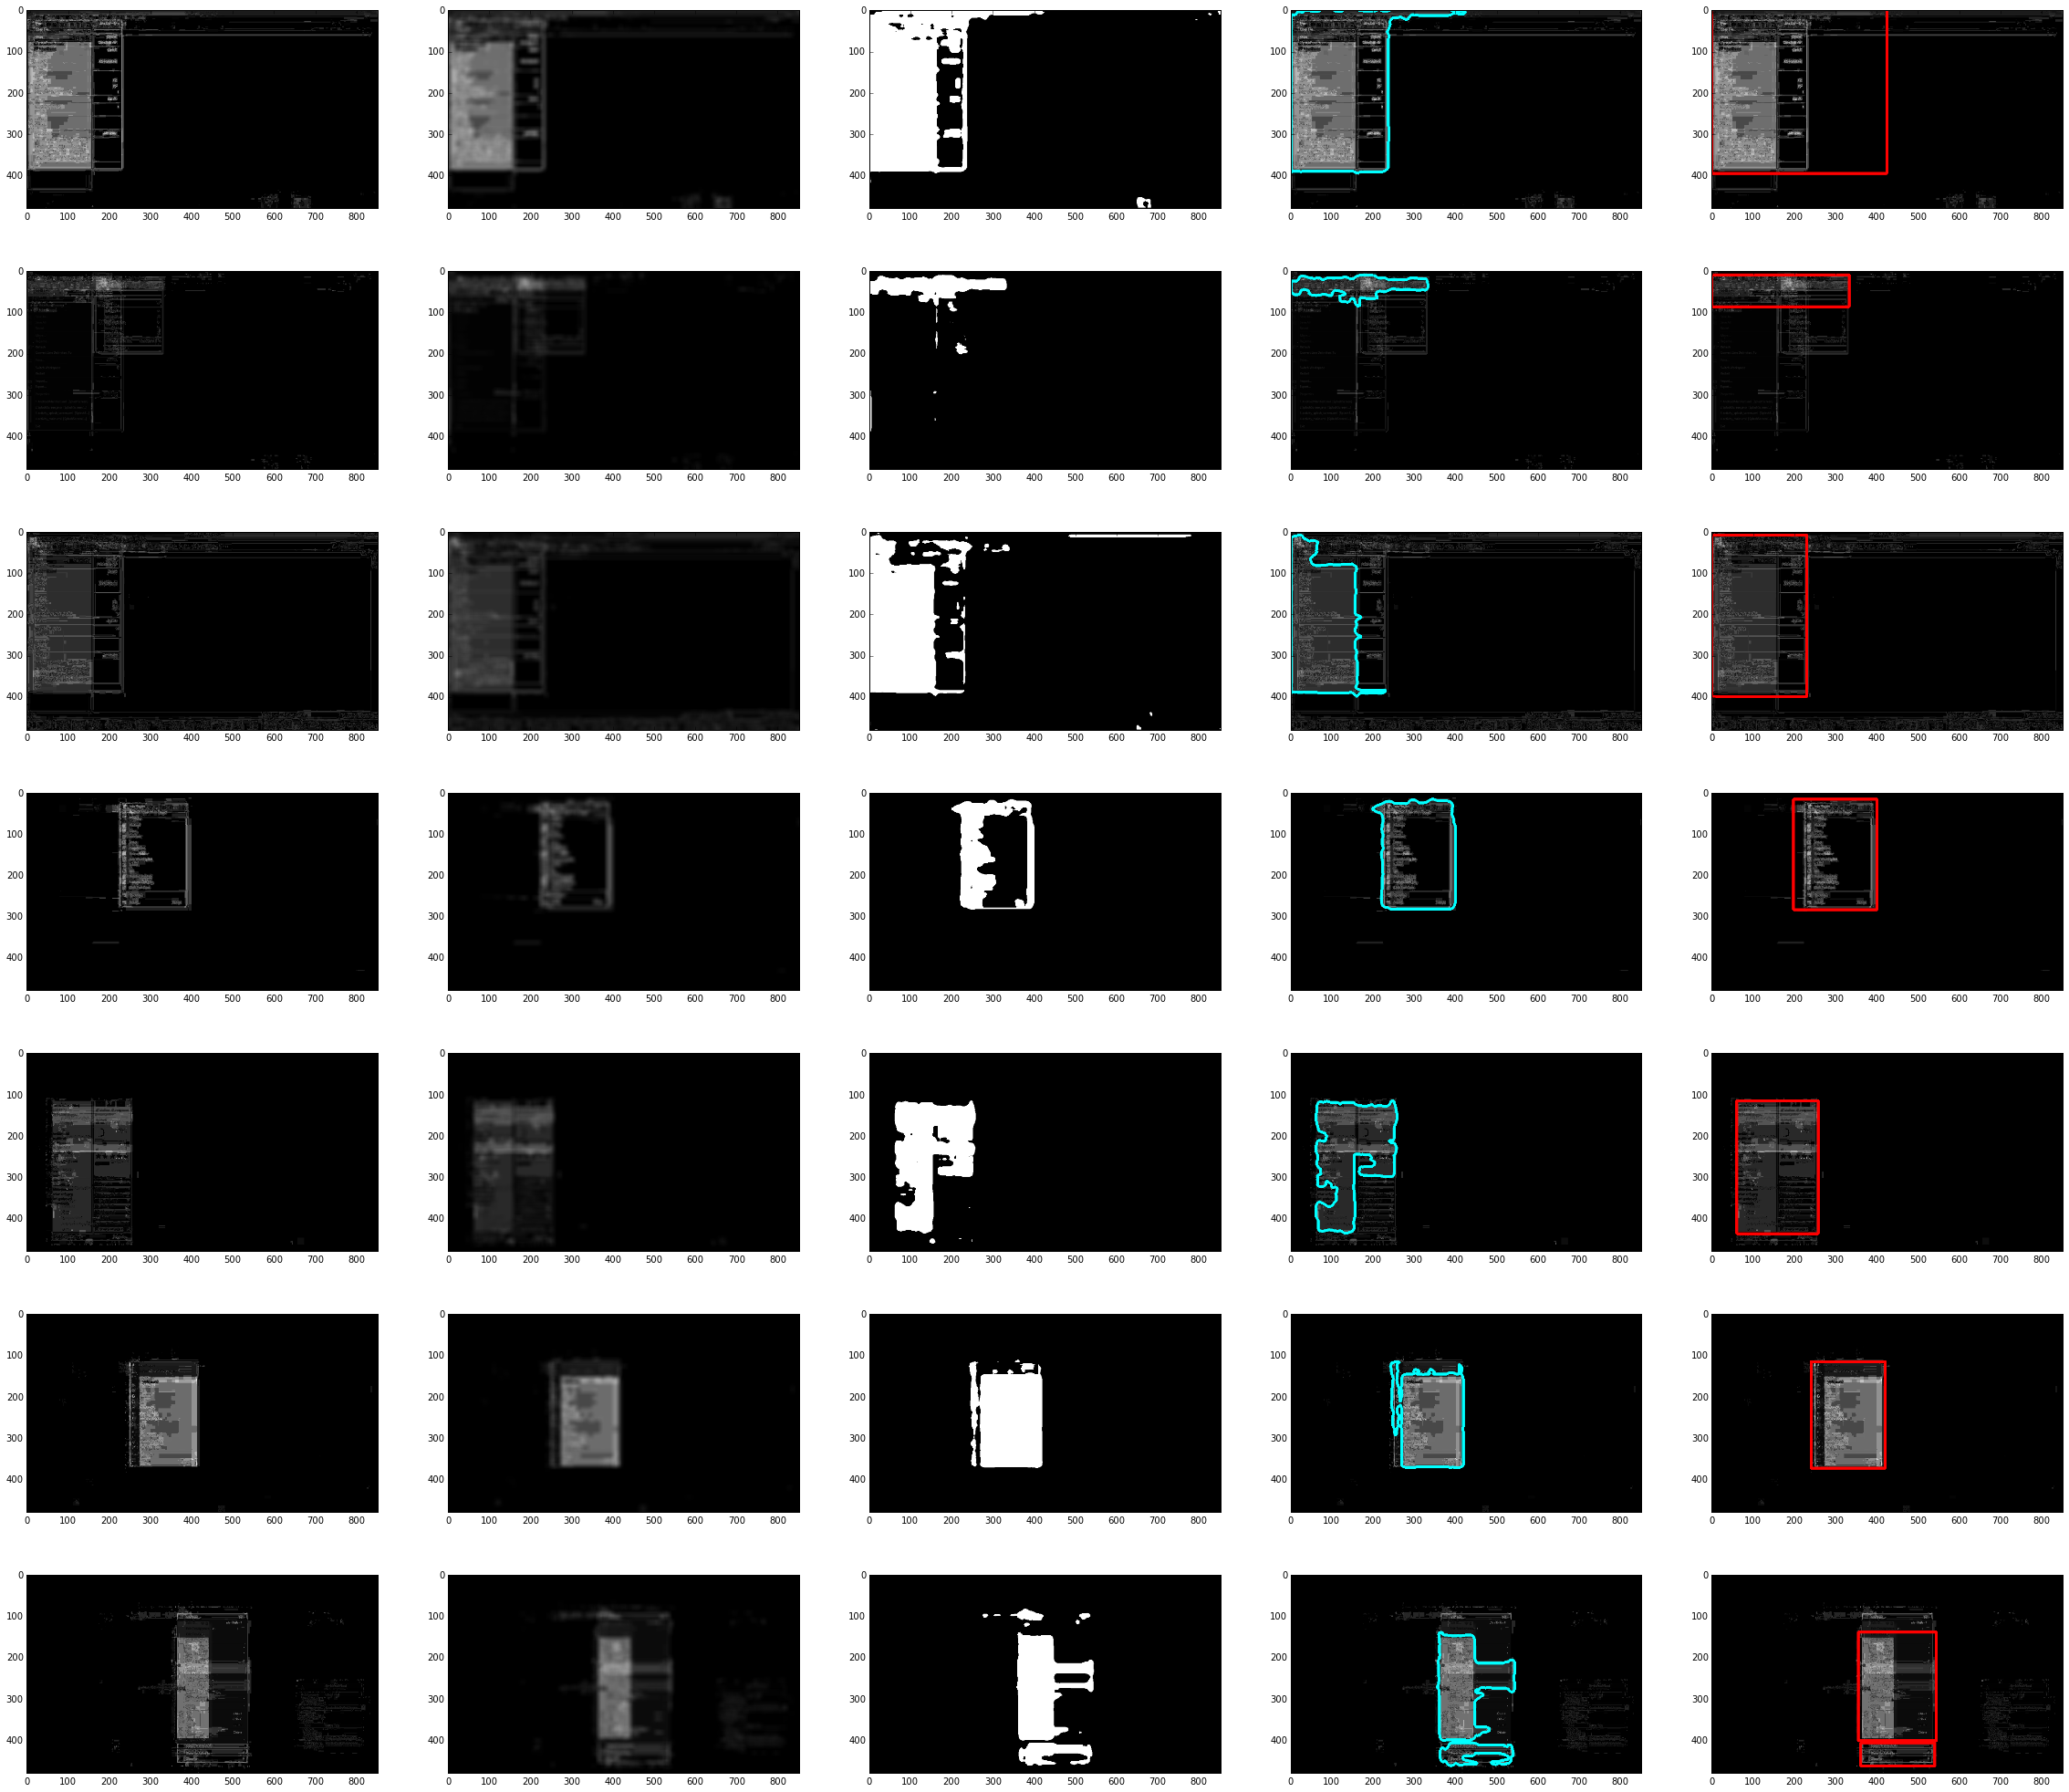

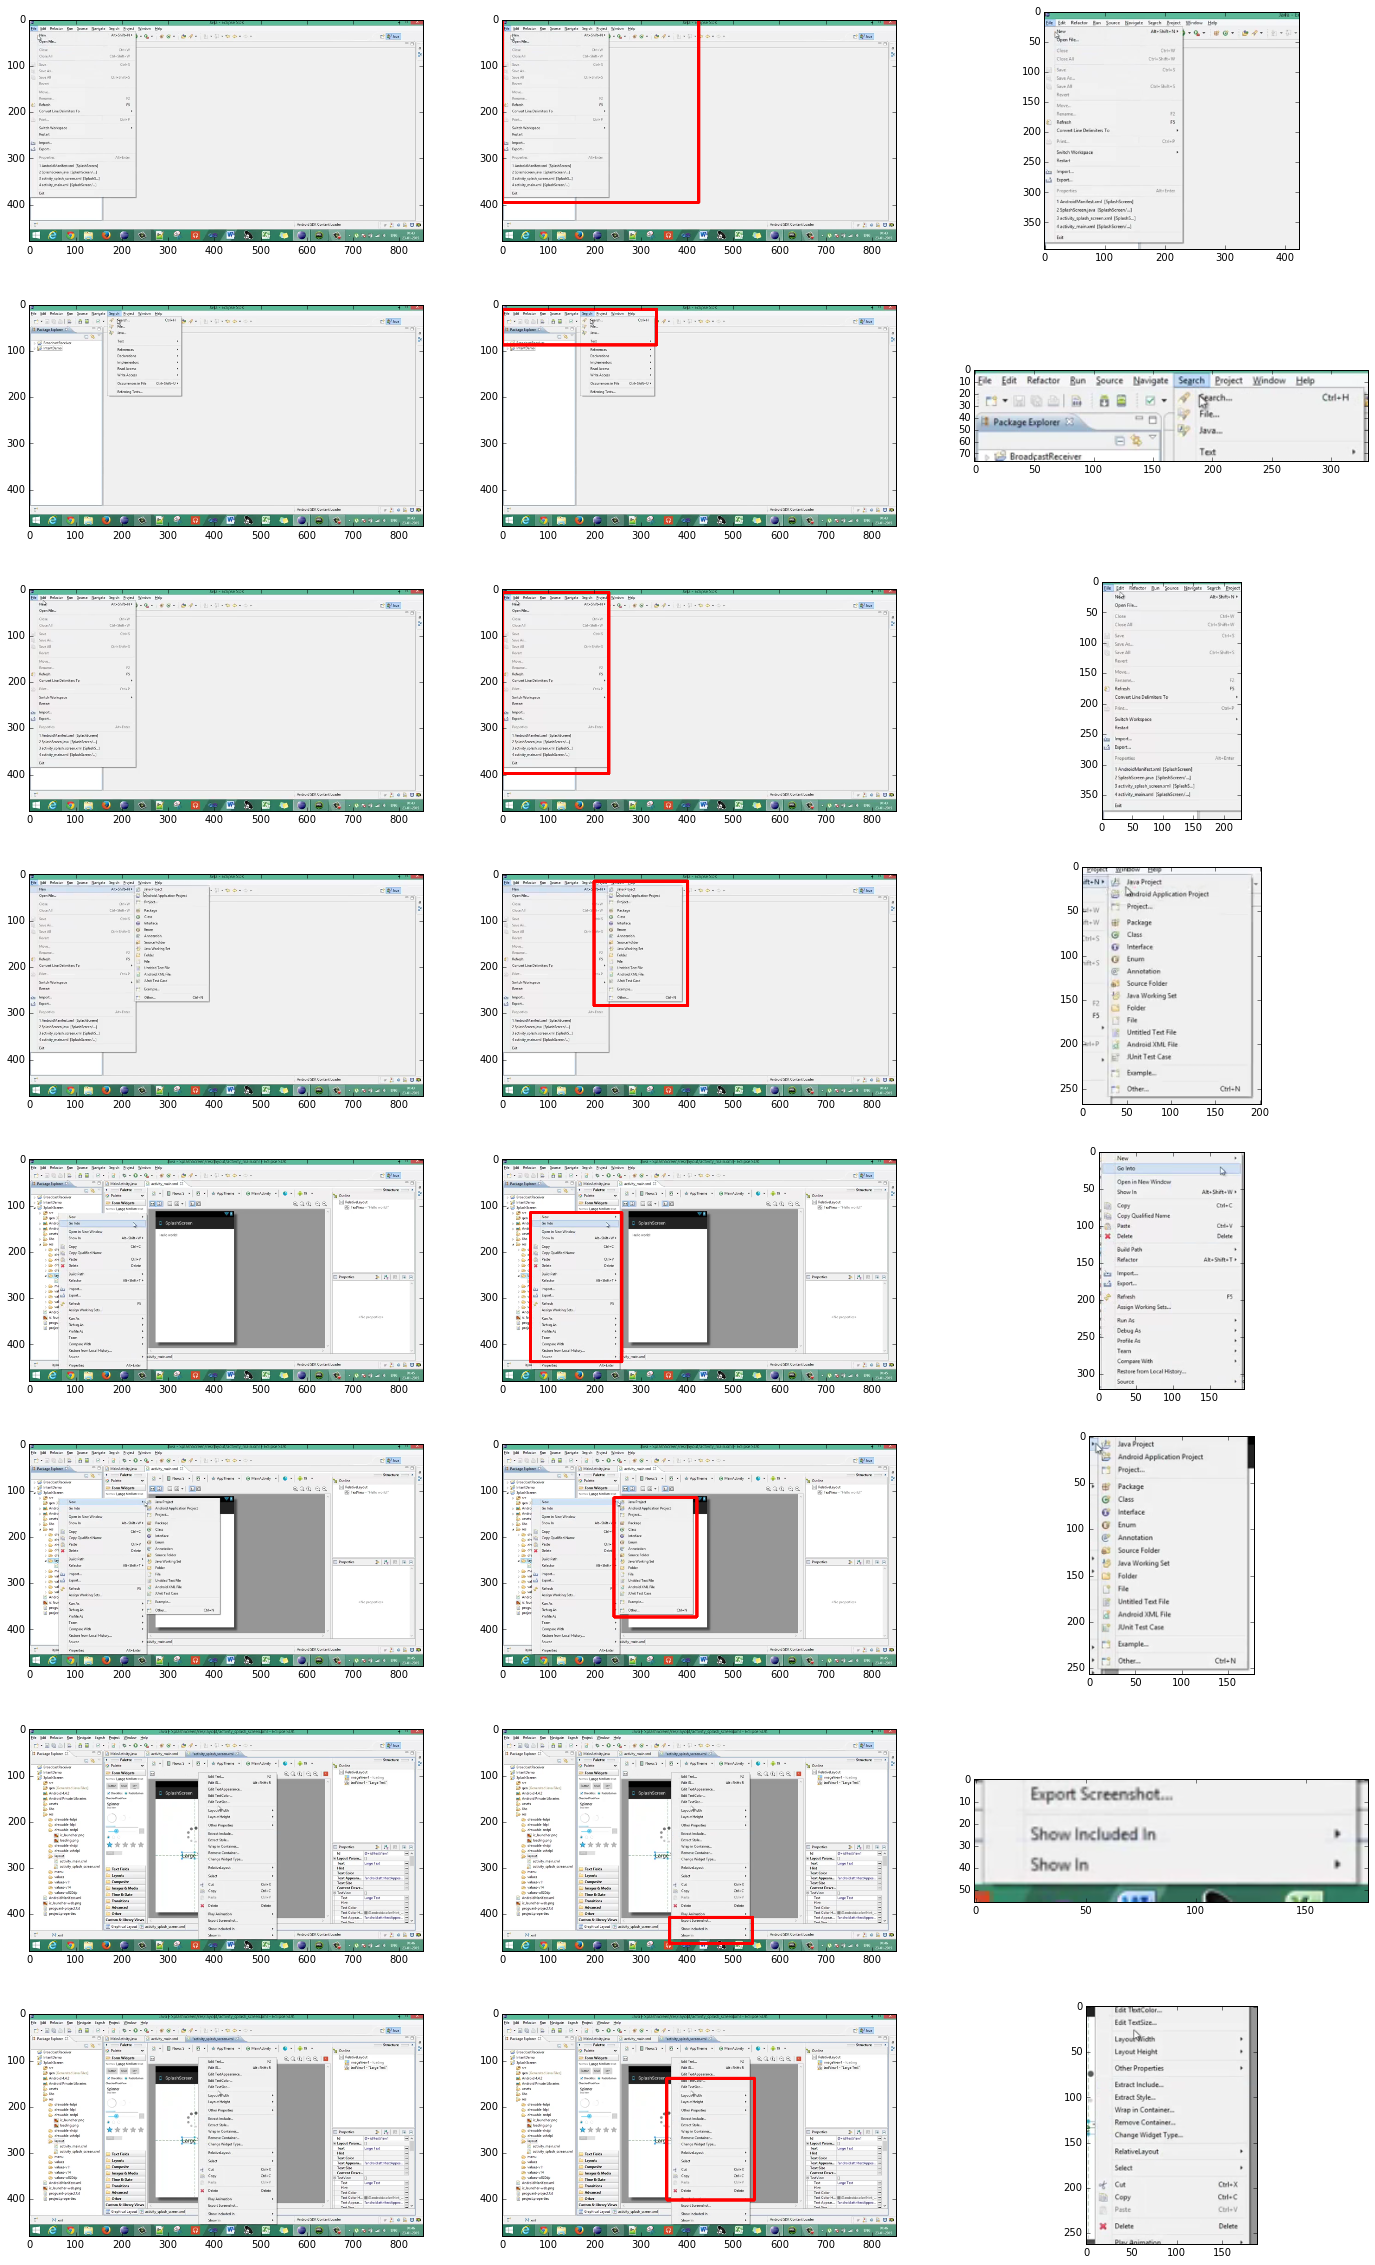

In [88]:
pipeline_imgs = []
regions_found = []

for ip in images:
    
    # Get contours for image
    diff_img = ip[1]
    blurred = blur_image(diff_img)
    binarized = binarize(blurred)
    contours = get_contours(binarized)
    rects = [cv2.boundingRect(c) for c in contours]
    
    # Display steps of image processing
    img = ip[0]
    contour_img = to_rgb(diff_img)
    cv2.drawContours(contour_img, contours, -1, (255,255,0), 5)
    grey_rect_img = to_rgb(diff_img)
    for r in rects:
        x, y, w, h = r
        cv2.rectangle(grey_rect_img, (x, y), (x + w, y + h), (0,0,255), 5)
        img_with_region = img.copy()
        cv2.rectangle(img_with_region, (x, y), (x + w, y + h), (0,0,255), 5)
        regions_found.append([img, img_with_region, img[y:y+h,x:x+w,:]])
    pipeline_imgs.append([
        to_rgb(diff_img), to_rgb(blurred), to_rgb(binarized)*255, contour_img, grey_rect_img,
    ])

display_image_matrix(pipeline_imgs)
display_image_matrix(regions_found)